Imports and pip installs

In [ ]:
!pip install scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import time
import random

Data Conversion

In [ ]:
# RSSI_AVG: Avg Signal Strength.
# RSSI_ST: Standard Deviation
# RSSI_SUM: The total Sum
# C_T(0-5): Length of time data was collected
# C_T(5-10): Length of time data was collected
# C_T(10-15): Length of time data was collected
# C_T(15-20): Length of time data was collected
# M_AVG: Average Number of times that Data was detected during fine grain time period

# C_T is going to be broken down to more components. Divide each 20 sec interval to 4 5 seconds intervals. M_AVG average amount of probes.
import json, codecs
import numpy as np
import math
import time
# Time, mac address, signal strenght, probe # devices

# Convert data json to np array
obj_text = codecs.open('data.json', 'r', encoding='utf-8').read()
b_new = json.loads(obj_text) #This reads json to list
data = np.array(b_new)       #This converts to numpy

# Convert labels json to np array
labels = []     #This converts to numpy array of integers


# Data declaration
# Data is held in a 2 dimensional array for each ping.
converted_data = [] # Look at top comment for order of the data points

#[0, 0, 0, 0, 0, 0, 0, 0]

# Calc RSSI_AVG and RSSI_SUM
firstTime = data[0][0]
nextBlock = float(firstTime) + 20
currRSSI_SUM = 0
currM_AVG = 0
stdevSet = []
numPoints = 0
labelAverage = 0

macDict = {} # Dictionary of MAC addresses and the amount of time

# Outer loop to go through json
for x in range(len(data)):
  if (float(data[x][0]) <= nextBlock): # Keep adding to the curr vars
    currRSSI_SUM += int(data[x][2]) # Update Sum
    stdevSet.append(data[x][2])              # Append the signal strength to the stdSet for calculation
    currM_AVG += int(data[x][3])                  # Update M_AVG
    numPoints += 1                           # Increment the number of points in this block
    labelAverage += int(data[x][4]) # Increment the label average

    # Length of specific MAC addresses
    if (data[x][1] in macDict):
      macDict[data[x][1]] = macDict[data[x][1]] + 1
    else:
      macDict[data[x][1]] = 1

  else: # This section we append to the converted_data list
    dataPoint = [0, 0, 0, 0, 0, 0, 0, 0]
    dataPoint[0] = currRSSI_SUM / numPoints   # RSSI_AVG
    dataPoint[2] = currRSSI_SUM               # RSSI_SUM
    dataPoint[7] = currM_AVG / numPoints      # M_AVG
    labels.append(labelAverage / numPoints)
    # Calculate STDEV
    for x in stdevSet:
      dataPoint[1] += (int(x) - dataPoint[0]) ** 2
    dataPoint[1] = math.sqrt(dataPoint[1] / numPoints)

    # Calculate C_T
    for item in macDict.values():
      if (item <= 5):
        dataPoint[3] += 1
      elif(item <= 10):
        dataPoint[4] += 1
      elif (item <= 15):
        dataPoint[5] += 1
      else:
        dataPoint[6] += 1
    # Append to the final set
    converted_data.append(dataPoint)

    # Reset for the next block
    nextBlock += 20
    currRSSI_SUM = 0
    currM_AVG = 0
    stdevSet = []
    numPoints = 0
    labelAverage = 0
    macDict.clear()
labels = np.array(labels, int)

KNN Classifier Code

Accuracy:  0.8


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Text(0, 0.5, 'Accuracy Score')

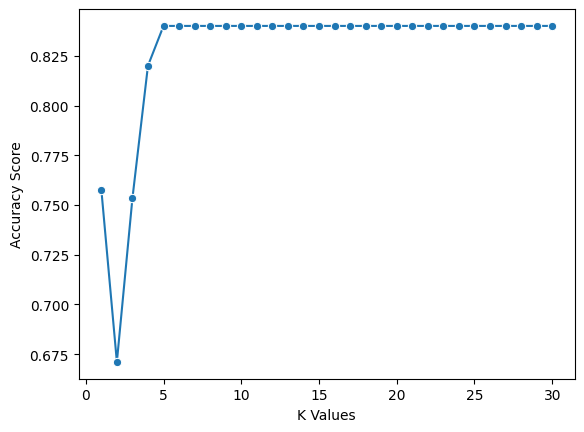

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(converted_data, labels, test_size=0.2)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fitting the model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Generate Predictions
y_pred = knn.predict(X_test)

# Accuracy Check
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Cross Fold Validation
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(converted_data)

# Try every value
for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  score = cross_val_score(knn, X, labels, cv=5)
  scores.append(np.mean(score))

# Visualize Results
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

Random Forest

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(converted_data, labels, test_size=0.2)

# Fit and Evaluate
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Accuracy
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Should we visualize?

Accuracy:  0.9


SVM

In [ ]:
from sklearn import svm
from sklearn import metrics
# Split the data
X_train, X_test, y_train, y_test = train_test_split(converted_data, labels, test_size=0.2)

# Create the classifier
clf = svm.SVC(kernel='linear')

# Train the model
clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.8


Data Visualization